# Notes on Chapter 11 of *Hands-On Machine Learning with Scikit-Learn, Keras, & TensorFlow*, 3rd edition, by Aurélien Géron

Reduce the amount of logging messages displayed by TensorFlow

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import itertools
import time

import keras
from keras import layers
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

In [3]:
# tf.config.experimental.enable_op_determinism() # can't use with MaxPool2D yet

It's important to choose a reasonable initialization of weights that won't lead to explosion of gradients in either the forward or backpropagation steps.

In general, Glorot initialization ($\sigma^2 = 1/n_{\textrm{avg}}$) should be used for identity/sigmoid/softmax/tanh activation functions, He initialization ($\sigma^2 = 2/n_{\textrm{in}}$) for ReLU derivatives, and LeCun initialization ($\sigma^2 = 1/n_{\textrm{in}}$) for SELU.

In keras, layer initialization can be specified when creating the layer, e.g.

In [4]:
layer1 = keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal")

It's also easy to set a custom variance scaling method, e.g.

In [5]:
my_initializer = keras.initializers.VarianceScaling(scale=2., mode="fan_avg", distribution="uniform")
layer2 = keras.layers.Dense(64, activation="leaky_relu", kernel_initializer=my_initializer)

Multiple activation functions are available; the author recommends `relu` or `leaky_relu` for shallow networks, and `swish` ($z \sigma(\beta z)$) for deep networks.

Batch normalization is another approach, i.e.

$$
z_{ij} = \gamma_j \frac{ x_{ij} - \bar x_j }{\sqrt{\sigma_j^2 + \epsilon}} + \beta_j
$$

where $\bar x$ is the vector mean of $x$ (estimated over the batch or as a running average), $\sigma_j$ is the (estimated) variance of $x_{ij}$ for a fixed $j$ (i.e. $\Sigma_{jj}$ if $\Sigma$ is the covariance matrix of $x$), $\epsilon$ is a smoothing constant (typically $10^{-5}$), and $\gamma$ and $\beta$ are (learnable) parameters.

Typically training will be slower per epoc due to the extra computation, but convergence will be faster leading to shorter overall training times. Adding batch normalization is as easy as just adding another layer (typically before or after each hidden layer's activation function:

In [6]:
layer3 = keras.layers.BatchNormalization()

It appears that there are ~4 parameters per input (estimates of $\bar x$ and $\sigma$ for each input and $\gamma$ and $\beta$ parameters).

In [7]:
m = keras.Sequential([
    keras.layers.Input((5,)),
    keras.layers.Dense(5, activation="relu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(3, activation="relu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),   
])
m.summary()
[(param.name, param.trainable) for param in m.layers[0].variables]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5)              │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3)              │            12 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 64 (256.00 B)

 Non-trainable params: 16 (64.00 B)

[('kernel', True), ('bias', True)]

There is debate about whether to add batch normalization after (as shown above) or before the activation function, but we can skip a redundant offset if we add it before the activation function: 

In [8]:
m = keras.Sequential([
    keras.layers.Input((5,)),
    keras.layers.Dense(5, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(3, kernel_initializer="he_normal", use_bias=False),
    keras.layers.Activation("relu"),
    keras.layers.BatchNormalization(),   
])
m.summary()
[(param.name, param.trainable) for param in m.layers[0].variables]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 5)              │            25 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5)              │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3)              │            12 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72 (288.00 B)

 Trainable params: 56 (224.00 B)

 Non-trainable params: 16 (64.00 B)

[('kernel', True)]

Two important parameters for batch normalization are `momentum` (i.e. the smoothing factor for the exponential weighted average) and `axis` (which defaults to -1, meaning the last axis in the typical (batch size, features) shape). For a convolutional network, batch normalization would typically be done across channels (rather than a spacial axis).

In some cases (e.g. recurrent neural networks) batch normalization can be difficult, in which case gradient clipping can be used to mitigate the effects of exploding gradients:

In [9]:
optimizer = keras.optimizers.Adam(clipvalue=0.9)
m.compile(optimizer=optimizer)

### Transfer learning

We'll work through an example from the book about transfer learning using the Fashion MNIST dataset. First we load the dataset and rescale the data from [0, 255] to [0.,1.]:

In [10]:
(X_fashion_train, y_fashion_train), (X_fashion_test, y_fashion_test) = keras.datasets.fashion_mnist.load_data()
fashion_class_names = ["T-shirt/top", "trouser", "pullover", "dress", 
                       "coat", "sandal", "shirt", "sneaker", "bag",
                       "ankle boot"]
X_fashion_train = X_fashion_train / 255
X_fashion_test = X_fashion_test / 255

Let's assume there is a standard dataset with everything but T-shirt/tops and shirts:

In [11]:
mask_old_fashion_train = (
        y_fashion_train != fashion_class_names.index("T-shirt/top")
    ) & (
        y_fashion_train != fashion_class_names.index("shirt")
    )
mask_old_fashion_train[:2000] = False
X_old_fashion_train = X_fashion_train[mask_old_fashion_train]
y_old_fashion_train = y_fashion_train[mask_old_fashion_train]

In [12]:
keras.utils.set_random_seed(42)
m_old_fashion = keras.Sequential([
    layers.Input(shape=(28,28)),
    layers.Reshape((28,28,1)),
    layers.Conv2D(8, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Conv2D(16, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(32, kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.Dense(len(fashion_class_names)),
    layers.Activation('softmax'),
])

In [13]:
m_old_fashion.compile(loss="sparse_categorical_crossentropy", 
    optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
history = m_old_fashion.fit(X_old_fashion_train, y_old_fashion_train, 
    batch_size=128, epochs=8, validation_split=0.1, verbose=0)

(0.0, 1.0)

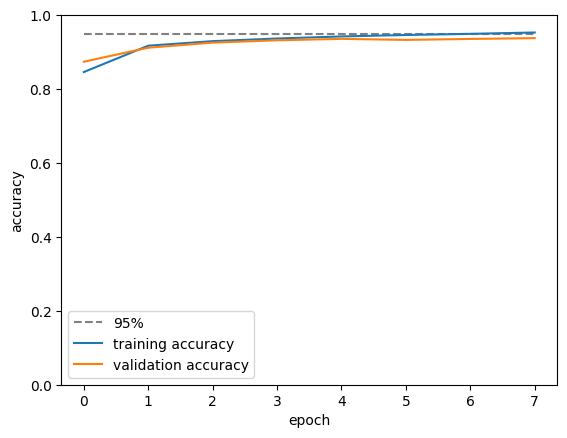

In [14]:
plt.hlines(0.95, 0, len(history.history['accuracy']) - 1, 
           linestyles='dashed', colors='gray', label="95%")
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim((0,1))

Let's also assume we have a much smaller dataset that is designed to detect T-shirts/tops among shirts:

In [15]:
mask_new_fashion_train = (
        y_fashion_train == fashion_class_names.index("T-shirt/top")
    ) | (
        y_fashion_train == fashion_class_names.index("shirt")
    )
mask_old_fashion_train[2000:] = False
X_new_fashion_train = X_fashion_train[mask_new_fashion_train][:200]
y_new_fashion_train = (
        y_fashion_train == fashion_class_names.index("T-shirt/top")
    )[mask_new_fashion_train][:200]

We first try to naively train a model on our new, smaller dataset:

In [16]:
keras.utils.set_random_seed(42)
m_new_fashion = keras.Sequential([
    layers.Input(shape=(28,28)),
    layers.Reshape((28,28,1)),
    layers.Conv2D(8, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Conv2D(16, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(32, kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.Dense(1),
    layers.Activation('sigmoid'),
])

In [17]:
m_new_fashion.compile(loss="binary_crossentropy", 
    optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
history = m_new_fashion.fit(X_new_fashion_train, y_new_fashion_train, 
    batch_size=128, epochs=30, validation_split=0.3, verbose=0)

(0.0, 1.0)

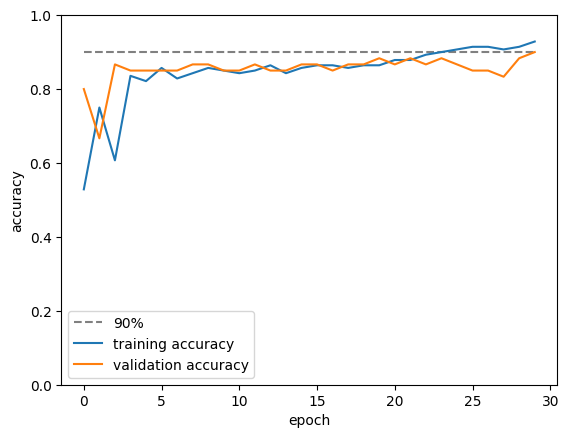

In [18]:
plt.hlines(0.9, 0, len(history.history['accuracy']) - 1, 
           linestyles='dashed', colors='gray', label="90%")
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim((0,1))

Alternatively we could try using transfer learning from the old model:

In [19]:
m_old_fashion_clone = keras.models.clone_model(m_old_fashion)
m_old_fashion_clone.set_weights(m_old_fashion.get_weights())
m_new_old_fashion = keras.Sequential(m_old_fashion_clone.layers[:-4])
m_new_old_fashion.add(layers.Dense(32, kernel_initializer="he_uniform"))
m_new_old_fashion.add(layers.Activation('leaky_relu'))
m_new_old_fashion.add(layers.Dense(1))
m_new_old_fashion.add(layers.Activation('sigmoid'))

We first train the model with the transferred layers frozen.

In [20]:
for layer in m_new_old_fashion.layers[:-4]:
    layer.trainable = False

In [21]:
m_new_old_fashion.compile(loss="binary_crossentropy", 
    optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=["accuracy"])
history = m_new_old_fashion.fit(X_new_fashion_train, y_new_fashion_train, 
    batch_size=128, epochs=10, validation_split=0.3, verbose=0)

(0.0, 1.0)

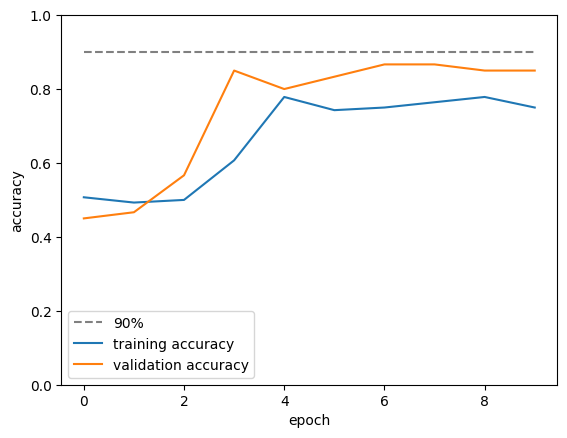

In [22]:
plt.hlines(0.9, 0, len(history.history['accuracy']) - 1, 
           linestyles='dashed', colors='gray', label="90%")
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim((0,1))

We then unfreeze most of the lower layers and train further (with a reduced learning rate):

In [23]:
for layer in m_new_old_fashion.layers[8:]:
    layer.trainable = True

In [24]:
m_new_old_fashion.compile(loss="binary_crossentropy", 
    optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
history = m_new_old_fashion.fit(X_new_fashion_train, y_new_fashion_train, 
    batch_size=128, epochs=30, validation_split=0.3, verbose=0)

(0.0, 1.0)

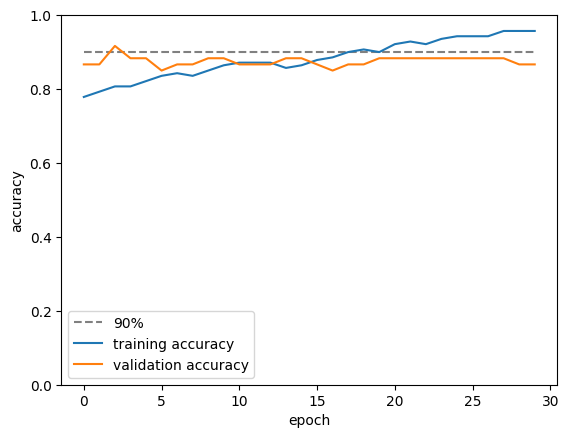

In [25]:
plt.hlines(0.9, 0, len(history.history['accuracy']) - 1, 
           linestyles='dashed', colors='gray', label="90%")
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim((0,1))

With this small of a dataset it's unclear whether transfer learning is helping us, but at least this demonstrates how one might use transfer learning.

### Learning rate schedules

There are multiple ways to set up learning rate schedules. Some optimizers natively support a decay rate for power scheduling, i.e.

$$\eta_t = \eta_0 (1 + t/s)^{-c},$$

where $t$ is the iteration number and $s$ and $c$ are hyperparameters. For example:

In [26]:
optimizer = keras.optimizers.Adam(weight_decay=1e-4)

Many other optimizers are built-in in the form of callbacks:

In [27]:
scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, persistence=4)
history = m_new_old_fashion.fit(X_new_fashion_train, y_new_fashion_train,
    callbacks=[scheduler],
    batch_size=128, epochs=20, validation_split=0.3, verbose=0)

(0.0, 1.0)

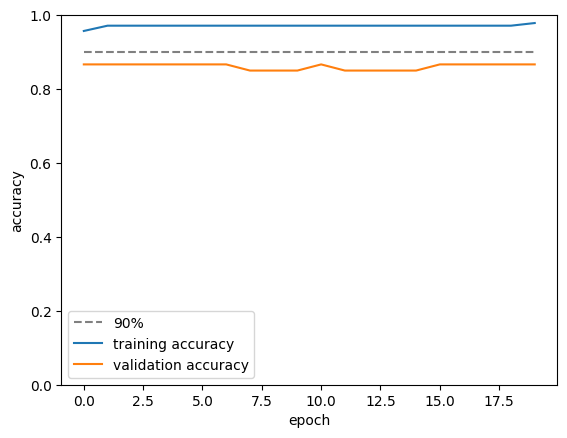

In [28]:
plt.hlines(0.9, 0, len(history.history['accuracy']) - 1, 
           linestyles='dashed', colors='gray', label="90%")
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim((0,1))

The callback approach can be used to create custom callbacks:

In [29]:
def my_learning_rate(epoch):
    return 0.01 * 0.5**(epoch/8)

scheduler = keras.callbacks.LearningRateScheduler(my_learning_rate)
history = m_new_old_fashion.fit(X_new_fashion_train, y_new_fashion_train,
    callbacks=[scheduler],
    batch_size=128, epochs=2, validation_split=0.3, verbose=0)

In addition, the various optimizers will accept a learning rate schedule parameter (which updates every step, and not just at each epoch):

In [30]:
learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.1)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate_schedule)

More generally, this can be any one-argument callable:

In [31]:
def my_learning_rate_schedule(step):
    return 0.001 * 0.999**step
optimizer = keras.optimizers.Adam(learning_rate=learning_rate_schedule)

### Regularization

Keras supports regularization on a layer-by-layer basis:

In [32]:
layer = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.02))

Max-norm regularization is implemented as a kernel constraint:

In [33]:
layer = layers.Dense(42, kernel_constraint=keras.constraints.max_norm(1.))

Note that regularization may interact poorly with various optimization methods (e.g. $L_2$ regularization will work with SGD but not with Adam).

### Dropout

Dropout is supported as a layer type in keras:

In [34]:
layer = layers.Dropout(rate=0.3)

Since dropout will lower the training loss where the dropout is applied (but not the validation loss where dropout is not used), it can sometimes be useful to also validate the model on the training dataset without dropout to detect overfitting. Typical dropout rates range from 10%-50% in general, usally 20%-30% in in recurrent neural networks and 40%-50% in convolutional neural networks. It may be useful to set dropout rate higher for larger layers and lower for smaller layers or even only use a dropout layer after the last 1-3 hidden layers.

In [35]:
keras.utils.set_random_seed(42)
m_fashion_dropout = keras.Sequential([
    layers.Input(shape=(28,28)),
    layers.Reshape((28,28,1)),
    layers.Conv2D(8, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Conv2D(16, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Dropout(rate=0.4),
    layers.Conv2D(32, (5,5), padding="same", kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.MaxPool2D(),
    layers.Dropout(rate=0.4),
    layers.Flatten(),
    layers.Dense(32, kernel_initializer="he_uniform"),
    layers.Activation('leaky_relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(len(fashion_class_names)),
    layers.Activation('softmax'),
])

In [36]:
learning_rate = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.005, decay_steps=10000, decay_rate=0.1)
m_fashion_dropout.compile(loss="sparse_categorical_crossentropy", 
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])
history = m_fashion_dropout.fit(X_fashion_train, y_fashion_train, 
    batch_size=256, epochs=10, validation_split=0.1, verbose=0)

(0.0, 1.0)

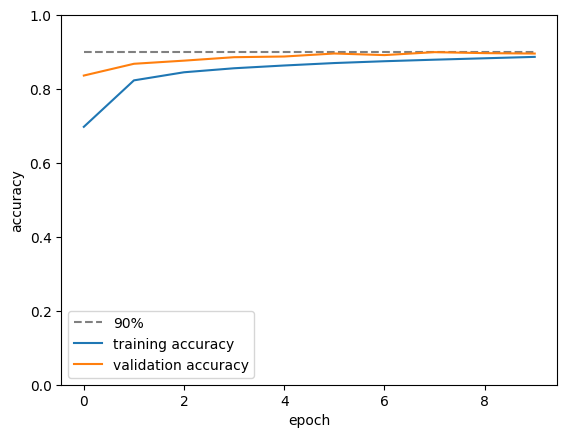

In [37]:
plt.hlines(0.90, 0, len(history.history['accuracy']) - 1, 
           linestyles='dashed', colors='gray', label="90%")
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim((0,1))

Note that dropout tends to slow convergence.

Dropout can be used as a way to capture model uncertainty in a Bayesean framework as described by Gal and Ghahrami (Gal Y, Ghahramani Z. Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning. Published online October 4, 2016.). In this context it is usually referred to as Monte Carlo Dropout, and can be used to sample the posterior of the parameter distribution:

In [38]:
samples = np.array([m_fashion_dropout(X_fashion_test, training=True) for _ in range(100)])

Text(0.5, 1.0, 'Mean probability')

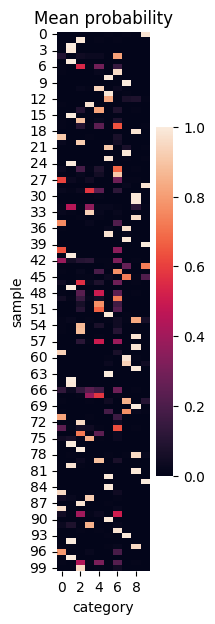

In [39]:
plt.figure(figsize=(1.5,7))
sns.heatmap(np.mean(samples, axis=0)[:100].round(2))
plt.xlabel('category')
plt.ylabel('sample');
plt.title('Mean probability')

Text(0.5, 1.0, 'sd(probability)')

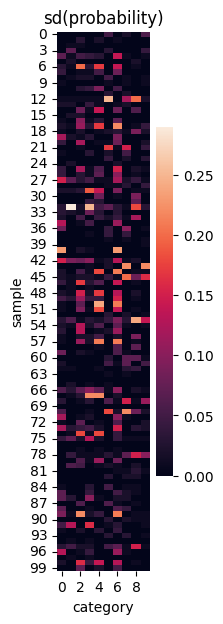

In [40]:
plt.figure(figsize=(1.5,7))
sns.heatmap(np.std(samples, axis=0)[:100].round(2))
plt.xlabel('category')
plt.ylabel('sample');
plt.title('sd(probability)')

Text(0.5, 0, 'Posterior probability')

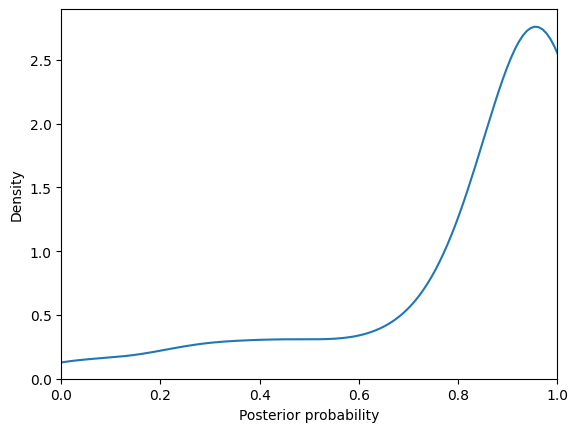

In [41]:
sns.kdeplot(samples[:,12,5])
plt.xlim(0,1)
plt.xlabel('Posterior probability')

Text(0.5, 0, 'Posterior probability')

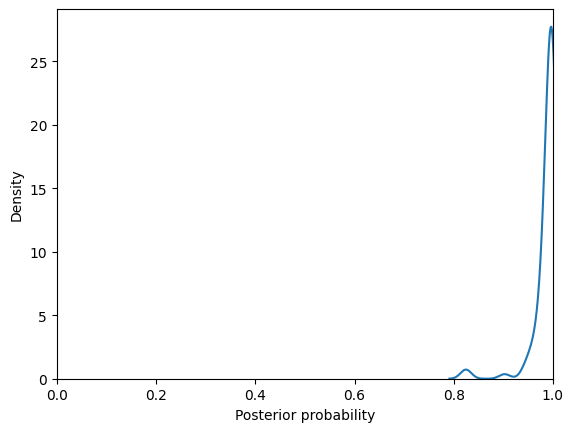

In [42]:
sns.kdeplot(samples[:,1,2])
plt.xlim(0,1)
plt.xlabel('Posterior probability')

## Exercises

### 1

Gradient explosion during forward or backward propagation

### 2

No - you will create a symmetry between units that will require an asymmetric source of noise (e.g. dropout) to break and poorly sample the space of possible units.

### 3

Yes - this will not block initial propagation of gradients.

### 4

- *None*: output layer in a scalar prediction (e.g. GDP)
- *tanh*: output bounded between 1 and -1 (e.g. output to a speed controller)
- *sigmoid*: output bounded between 0 and 1 (e.g. output of a probability)
- *softmax*: output of probabilities for multiple, mutually exclusive events.
- *ReLU*: great for something that needs to be fast at runtime
- *LeakyReLU*: like ReLU, but better training performance
- *ELU, GELU, and SWISH*: faster convergence per epoch, e.g. if the bottleneck is streaming the training data
- *SELU*: MLP design without needing to add normalization approaches

### 5
Large oscillations

### 6

1) Use $L_1$ regularization
2) Train the full model, then force sufficiently small weight to zero and retrain the remaining model
3) Use a model optimization tool

### 7
Yes, no, yes

### 8

Note: the model designs used in this answer are not good designs for this dataset (as noted by the author), but are used as they are specified by the question.

#### a. Initial model

In [43]:
m1 = keras.Sequential(list(itertools.chain(
    [
        layers.Input((32,32,3)),
        layers.Flatten(),
    ],
    *[
        [
            layers.Dense(100, kernel_initializer='he_normal'),
            layers.Activation('swish'),
        ]
        for _ in range(20)
    ],
    [
        layers.Dense(10),
        layers.Activation('softmax'),
    ]
)))
#m1.summary()

#### b. Model training

In [44]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

First, find a reasonable learning rate:

In [45]:
class PerBatchLossCallback(keras.callbacks.Callback):
    def __init__(self):
        self.loss = []
        self.batch = []
        
    def on_train_batch_end(self, batch, logs):
        if logs and ('loss' in logs) and np.isfinite(logs['loss']):
            self.loss.append(logs['loss'])
            self.batch.append(batch)

In [46]:
m = keras.models.clone_model(m1)
def my_learning_rate_schedule(step):
    return 1e-5 * 10**(step/100)
optimizer = keras.optimizers.Nadam(learning_rate=my_learning_rate_schedule)
m.compile(loss="sparse_categorical_crossentropy", 
    optimizer=optimizer, metrics=["accuracy"])
val_loss_callback = PerBatchLossCallback()
history = m.fit(X_train, y_train, batch_size=128, epochs=2,
    validation_split=0.3, verbose=0, callbacks=[val_loss_callback])

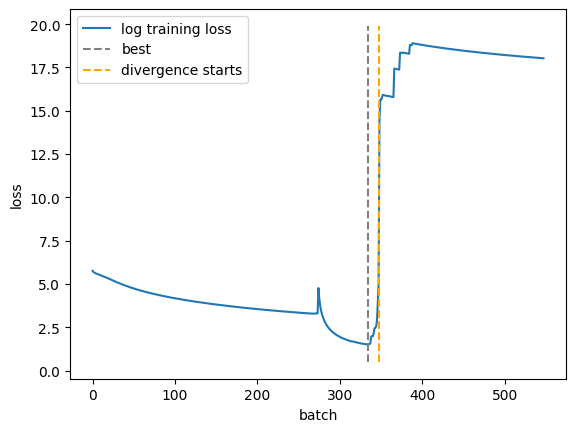

In [47]:
plt.plot(np.log(val_loss_callback.loss), label='log training loss')
loss = np.array(val_loss_callback.loss)
best_batch = np.argmin(loss)
divergence_start = np.arange(loss.shape[0])[loss <= loss[0]][-1]
plt.vlines(best_batch, np.log(np.min(val_loss_callback.loss)) - 1, 
    np.log(np.max(val_loss_callback.loss)) + 1,
    linestyles='dashed', colors='gray', label="best")
plt.vlines(divergence_start, np.log(np.min(val_loss_callback.loss)) - 1, 
    np.log(np.max(val_loss_callback.loss)) + 1,
    linestyles='dashed', colors='orange', label="divergence starts")
plt.legend()
plt.xlabel('batch')
plt.ylabel('loss')
learning_rate = my_learning_rate_schedule(divergence_start)/10

Now train the model using early stopping

In [48]:
start = time.monotonic()
m = keras.models.clone_model(m1)
optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
m.compile(loss="sparse_categorical_crossentropy", 
    optimizer=optimizer, metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
history1 = m.fit(X_train, y_train, batch_size=128, epochs=100,
    validation_split=0.3, verbose=0, callbacks=[early_stopping])
print(f"Elapsed time: {time.monotonic() - start} s")

Elapsed time: 50.34774434403516 s


(0.0, 1.0)

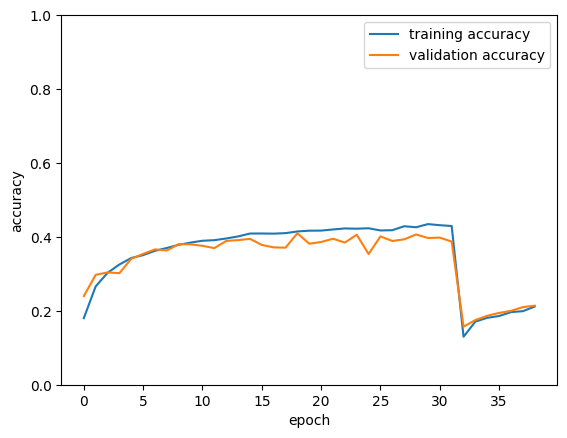

In [49]:
plt.plot(history1.history['accuracy'], label='training accuracy')
plt.plot(history1.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim((0,1))

In [50]:
m.evaluate(X_test, y_test, verbose=0)

[1.6434000730514526, 0.41119998693466187]

#### c. Batch normalization

In [51]:
m2 = keras.Sequential(list(itertools.chain(
    [
        layers.Input((32,32,3)),
        layers.Flatten(),
    ],
    *[
        [
            layers.Dense(100, kernel_initializer='he_normal', use_bias=False),
            layers.BatchNormalization(),
            layers.Activation('swish'),
        ]
        for _ in range(20)
    ],
    [
        layers.Dense(10),
        layers.Activation('softmax'),
    ]
)))
#m1.summary()

In [52]:
m = keras.models.clone_model(m2)
def my_learning_rate_schedule(step):
    return 1e-5 * 10**(step/100)
optimizer = keras.optimizers.Nadam(learning_rate=my_learning_rate_schedule)
m.compile(loss="sparse_categorical_crossentropy", 
    optimizer=optimizer, metrics=["accuracy"])
val_loss_callback = PerBatchLossCallback()
history = m.fit(X_train, y_train, batch_size=128, epochs=3,
    validation_split=0.3, verbose=0, callbacks=[val_loss_callback])

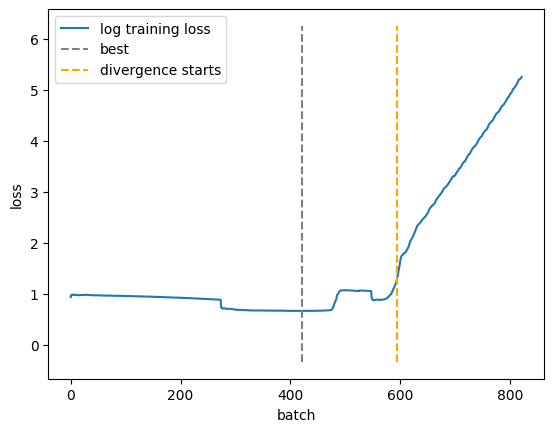

In [53]:
plt.plot(np.log(val_loss_callback.loss), label='log training loss')
loss = np.array(val_loss_callback.loss)
best_batch = np.argmin(loss)
divergence_start = np.arange(loss.shape[0])[loss <= loss[0] * 1.5][-1]
plt.vlines(best_batch, np.log(np.min(val_loss_callback.loss)) - 1, 
    np.log(np.max(val_loss_callback.loss)) + 1,
    linestyles='dashed', colors='gray', label="best")
plt.vlines(divergence_start, np.log(np.min(val_loss_callback.loss)) - 1, 
    np.log(np.max(val_loss_callback.loss)) + 1,
    linestyles='dashed', colors='orange', label="divergence starts")
plt.legend()
plt.xlabel('batch')
plt.ylabel('loss')
learning_rate = my_learning_rate_schedule(divergence_start)/10

In [54]:
start = time.monotonic()
m = keras.models.clone_model(m2)
optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
m.compile(loss="sparse_categorical_crossentropy", 
    optimizer=optimizer, metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
history2 = m.fit(X_train, y_train, batch_size=128, epochs=100,
    validation_split=0.3, verbose=0, callbacks=[early_stopping])
print(f"Elapsed time: {time.monotonic() - start} s")

Elapsed time: 60.375305362045765 s


(0.0, 1.0)

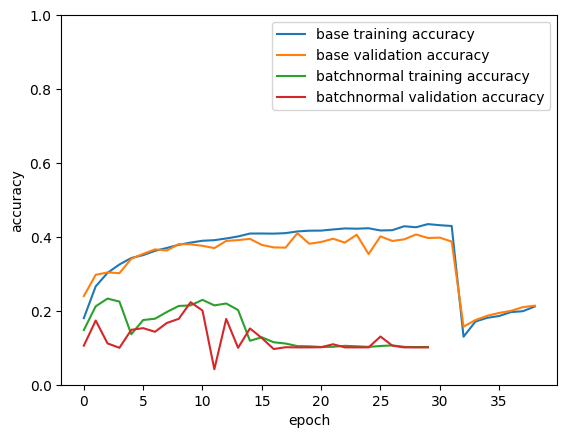

In [55]:
plt.plot(history1.history['accuracy'], label='base training accuracy')
plt.plot(history1.history['val_accuracy'], label='base validation accuracy')
plt.plot(history2.history['accuracy'], label='batchnormal training accuracy')
plt.plot(history2.history['val_accuracy'], label='batchnormal validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim((0,1))

In [56]:
m.evaluate(X_test, y_test, verbose=0)

[2.0004210472106934, 0.22709999978542328]

#### d. Self normalization

In [57]:
m3 = keras.Sequential(list(itertools.chain(
    [
        layers.Input((32,32,3)),
        layers.Flatten(),
    ],
    *[
        [
            layers.Dense(100, kernel_initializer='lecun_normal', use_bias=False),
            layers.Activation('selu'),
        ]
        for _ in range(20)
    ],
    [
        layers.Dense(10),
        layers.Activation('softmax'),
    ]
)))
#m1.summary()

In [58]:
m = keras.models.clone_model(m3)
def my_learning_rate_schedule(step):
    return 1e-5 * 10**(step/100)
optimizer = keras.optimizers.Nadam(learning_rate=my_learning_rate_schedule)
m.compile(loss="sparse_categorical_crossentropy", 
    optimizer=optimizer, metrics=["accuracy"])
val_loss_callback = PerBatchLossCallback()
history = m.fit(X_train, y_train, batch_size=128, epochs=2,
    validation_split=0.3, verbose=0, callbacks=[val_loss_callback])

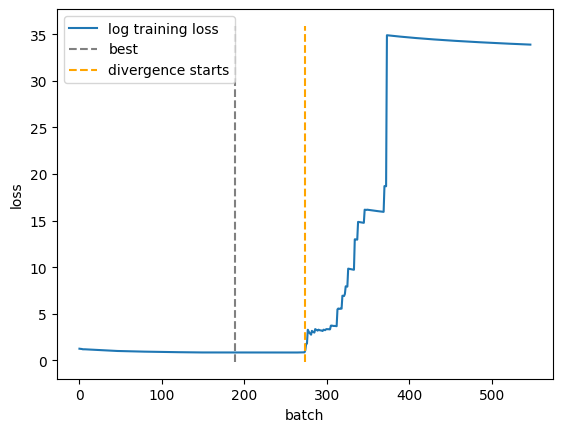

In [59]:
plt.plot(np.log(val_loss_callback.loss), label='log training loss')
loss = np.array(val_loss_callback.loss)
best_batch = np.argmin(loss)
divergence_start = np.arange(loss.shape[0])[loss <= loss[0]][-1]
plt.vlines(best_batch, np.log(np.min(val_loss_callback.loss)) - 1, 
    np.log(np.max(val_loss_callback.loss)) + 1,
    linestyles='dashed', colors='gray', label="best")
plt.vlines(divergence_start, np.log(np.min(val_loss_callback.loss)) - 1, 
    np.log(np.max(val_loss_callback.loss)) + 1,
    linestyles='dashed', colors='orange', label="divergence starts")
plt.legend()
plt.xlabel('batch')
plt.ylabel('loss')
learning_rate = my_learning_rate_schedule(divergence_start)/10

In [60]:
start = time.monotonic()
m = keras.models.clone_model(m3)
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, nesterov=True)
m.compile(loss="sparse_categorical_crossentropy", 
    optimizer=optimizer, metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
history3 = m.fit(X_train, y_train, batch_size=128, epochs=100,
    validation_split=0.3, verbose=0, callbacks=[early_stopping])
print(f"Elapsed time: {time.monotonic() - start} s")

Elapsed time: 70.32179137598723 s


(0.0, 1.0)

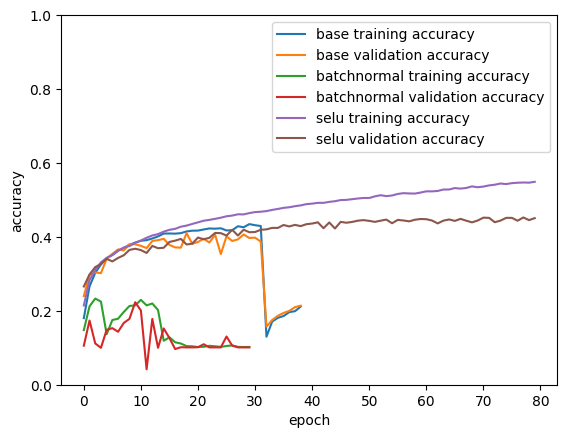

In [61]:
plt.plot(history1.history['accuracy'], label='base training accuracy')
plt.plot(history1.history['val_accuracy'], label='base validation accuracy')
plt.plot(history2.history['accuracy'], label='batchnormal training accuracy')
plt.plot(history2.history['val_accuracy'], label='batchnormal validation accuracy')
plt.plot(history3.history['accuracy'], label='selu training accuracy')
plt.plot(history3.history['val_accuracy'], label='selu validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim((0,1))

In [62]:
m.evaluate(X_test, y_test, verbose=0)

[1.5394989252090454, 0.45899999141693115]

In [63]:
np.mean(np.argmax(m(X_test), axis=1) == y_test[:,0])

0.4588

#### e. $\alpha$-dropout

In [64]:
m4 = keras.Sequential(list(itertools.chain(
    [
        layers.Input((32,32,3)),
        layers.Flatten(),
    ],
    *[
        [
            layers.Dense(100, kernel_initializer='lecun_normal', use_bias=False),
            layers.Activation('selu'),
        ]
        for _ in range(16)
    ],
    *[
        [
            layers.Dense(100, kernel_initializer='lecun_normal', use_bias=False),
            layers.Activation('selu'),
            layers.AlphaDropout(0.2, (128, 100)),
        ]
        for _ in range(4)
    ],
    [
        layers.Dense(10),
        layers.Activation('softmax'),
    ]
)))
#m1.summary()

In [65]:
m = keras.models.clone_model(m4)
def my_learning_rate_schedule(step):
    return 1e-5 * 10**(step/100)
optimizer = keras.optimizers.Nadam(learning_rate=my_learning_rate_schedule)
m.compile(loss="sparse_categorical_crossentropy", 
    optimizer=optimizer, metrics=["accuracy"])
val_loss_callback = PerBatchLossCallback()
trunc_len = 128 * (X_train.shape[0] // 128)
history = m.fit(X_train[:trunc_len], y_train[:trunc_len], batch_size=128, epochs=3,
    validation_split=0.3, verbose=0, callbacks=[val_loss_callback])

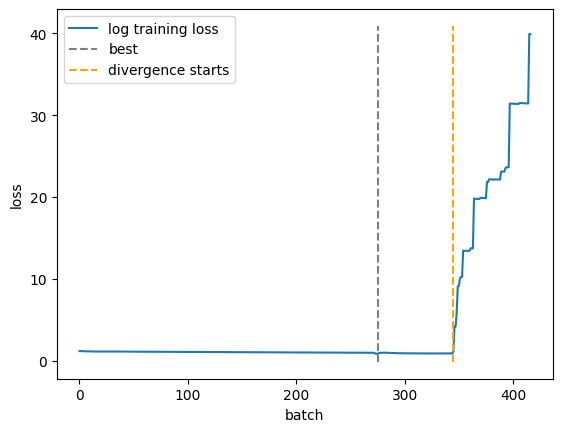

In [66]:
plt.plot(np.log(val_loss_callback.loss), label='log training loss')
loss = np.array(val_loss_callback.loss)
best_batch = np.argmin(loss)
divergence_start = np.arange(loss.shape[0])[loss <= loss[0]][-1]
plt.vlines(best_batch, np.log(np.min(val_loss_callback.loss)) - 1, 
    np.log(np.max(val_loss_callback.loss)) + 1,
    linestyles='dashed', colors='gray', label="best")
plt.vlines(divergence_start, np.log(np.min(val_loss_callback.loss)) - 1, 
    np.log(np.max(val_loss_callback.loss)) + 1,
    linestyles='dashed', colors='orange', label="divergence starts")
plt.legend()
plt.xlabel('batch')
plt.ylabel('loss')
learning_rate = my_learning_rate_schedule(divergence_start)/100

In [67]:
start = time.monotonic()
m = keras.models.clone_model(m4)
optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
m.compile(loss="sparse_categorical_crossentropy", 
    optimizer=optimizer, metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)
history4 = m.fit(X_train[:trunc_len], y_train[:trunc_len], batch_size=128, epochs=100,
    validation_split=0.3, verbose=0, callbacks=[early_stopping])
print(f"Elapsed time: {time.monotonic() - start} s")

Elapsed time: 40.66116601205431 s


(0.0, 1.0)

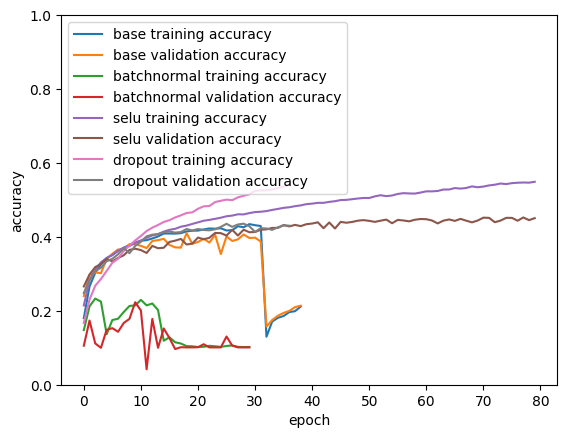

In [68]:
plt.plot(history1.history['accuracy'], label='base training accuracy')
plt.plot(history1.history['val_accuracy'], label='base validation accuracy')
plt.plot(history2.history['accuracy'], label='batchnormal training accuracy')
plt.plot(history2.history['val_accuracy'], label='batchnormal validation accuracy')
plt.plot(history3.history['accuracy'], label='selu training accuracy')
plt.plot(history3.history['val_accuracy'], label='selu validation accuracy')
plt.plot(history4.history['accuracy'], label='dropout training accuracy')
plt.plot(history4.history['val_accuracy'], label='dropout validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim((0,1))

In [69]:
test_truc_len = 128 * (X_test.shape[0] // 128)
m.evaluate(X_test[:test_truc_len], y_test[:test_truc_len], verbose=0)

[1.8182299137115479, 0.36247995495796204]

In [70]:
np.mean(np.argmax(m(X_test), axis=1) == y_test[:,0])

0.3624

In [71]:
def sample_m(X):
    return np.vstack([
        m(X[i:i+128], training=True)
        for i in range(0, X.shape[0] - 127, 128)
    ])
sample_m(X_test).shape

(9984, 10)

In [72]:
samples = np.array([
    sample_m(X_test)
    for i in range(100)
])
mc_dropout_prediction = np.mean(samples, axis=0)

In [73]:
np.mean(np.argmax(mc_dropout_prediction, axis=1) == y_test[:128*(y_test.shape[0]//128),0])

0.379306891025641

#### f. 1-cycle scheduling

In [74]:
my_learning_rate_schedule(3)

1.0715193052376065e-05

In [75]:
total_epochs = 40
total_steps = trunc_len * total_epochs
halfway = total_steps // 2

def my_learning_rate_schedule(step):
    return learning_rate * 10**-tf.abs(step/halfway - 1)

def my_beta_1_schedule(step):
    return 0.85 + 0.1*tf.abs(step/halfway - 1)

start = time.monotonic()
m = keras.models.clone_model(m4)
optimizer = keras.optimizers.Nadam(
    learning_rate=my_learning_rate_schedule,
    #beta_1=my_beta_1_schedule,
)
m.compile(loss="sparse_categorical_crossentropy", 
    optimizer=optimizer, metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)
history5 = m.fit(X_train[:trunc_len], y_train[:trunc_len], batch_size=128, epochs=100,
    validation_split=0.3, verbose=0, callbacks=[early_stopping])
print(f"Elapsed time: {time.monotonic() - start} s")

Elapsed time: 53.61477825511247 s


(0.0, 1.0)

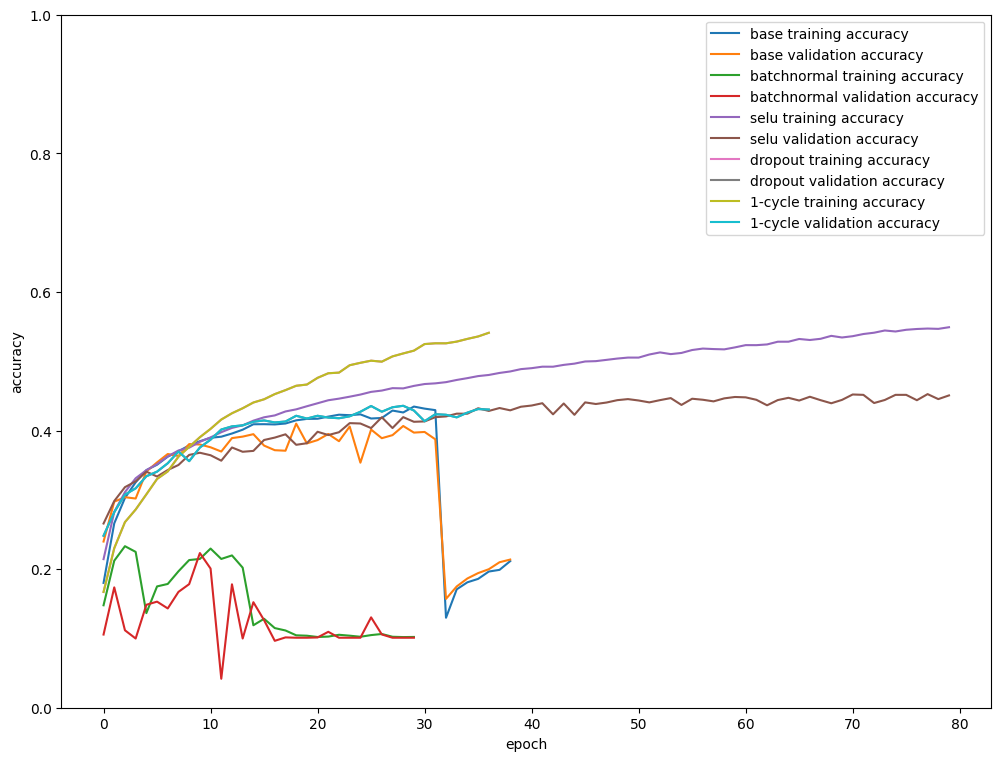

In [76]:
plt.figure(figsize=(12,9))
plt.plot(history1.history['accuracy'], label='base training accuracy')
plt.plot(history1.history['val_accuracy'], label='base validation accuracy')
plt.plot(history2.history['accuracy'], label='batchnormal training accuracy')
plt.plot(history2.history['val_accuracy'], label='batchnormal validation accuracy')
plt.plot(history3.history['accuracy'], label='selu training accuracy')
plt.plot(history3.history['val_accuracy'], label='selu validation accuracy')
plt.plot(history4.history['accuracy'], label='dropout training accuracy')
plt.plot(history4.history['val_accuracy'], label='dropout validation accuracy')
plt.plot(history4.history['accuracy'], label='1-cycle training accuracy')
plt.plot(history4.history['val_accuracy'], label='1-cycle validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim((0,1))

In [77]:
test_truc_len = 128 * (X_test.shape[0] // 128)
m.evaluate(X_test[:test_truc_len], y_test[:test_truc_len], verbose=0)

[1.7828073501586914, 0.40895432233810425]

In [78]:
np.mean(np.argmax(m(X_test), axis=1) == y_test[:,0])

0.4089

In [79]:
def sample_m(X):
    return np.vstack([
        m(X[i:i+128], training=True)
        for i in range(0, X.shape[0] - 127, 128)
    ])

In [80]:
samples = np.array([
    sample_m(X_test)
    for i in range(100)
])
mc_dropout_prediction = np.mean(samples, axis=0)

In [81]:
np.mean(np.argmax(mc_dropout_prediction, axis=1) == y_test[:128*(y_test.shape[0]//128),0])

0.4120592948717949